HomeWork 2's Report:

Tasks:
1. Implement and test AutoEncoder
2. Optimize Hyperparameters
3. Fine-tune the AutoEncoder by using a supervised classification task(compare it with the previous homework)
4. Explore the latent space structure
5. Implement and test Variational AutoEncoder 


Introduction

The Goals of this homework was writtent as tasks above and the basic strategies is to define an AutoEncoder. In order to do so we should have an Encoder part and a Decoder part which both of them are convolutional neural networks. The Encoder part tries to encode the data into a latent space with a specified dimention. Then the Decoder part is trying to decode the latent space to actual space of data and reproduce them. 

In this homework I used the Optuna to optimize the hyperparameters. And after finding the best ones and creating an AutoEncoder with those hyperparameters, the results were driven by Cross-Validation method(which devide the data set into k parts and use k-1 of them as training data and one of them as validation and this procedure happens k time. then the result will be the average of all the k results).

In AutoEncoder method we won't need the label of the data(it is an unsupervised method), but since the  data are Fashion Mnist datasets the labels are also available. therefor we can use them to appreciate the accuracy of unsupervised method. in order to do so, we should encode the data with their correspondin labels by Encoder and then try to classify the latent space into 10 classes with tSNE method(since we have the labels). Then if we take a random sample from those classes and decode them into real space, we can plot the picture and see the result(the anticipated class).

Methods

1. Encoder:

it is a convolutional neural network which contains three convolutional network followed by two fully connected network. The inputs are two-dimention pictures of Fashion mnist(as tensor type) and the output is a tensor of specified latent space dimention.

2. Decoder:

it is also another convolutional network which contains 2 layers of fully connected network followed by three transposed convolution(reverse of convolution). the inputs are tensor of latent space and the output is two dimention pictures(reproduced pictures).

3. Optuna:

optuna is used to find the best hyperparameters of this task. to do so, first we need to define a model that optuna will have for differen trials. then we should specify different hayperparameters that we want them to be tuned. then after a fixed number of trials we will have the best trial with the best hyperparameters. in this task the hyperparameters are latent space, opimizing method, learning rate and regulation rate.

4. Variational-AutoEncoder(VAE):



Results





In [1]:
! pip install optuna

import os
import torch
import optuna
import torchvision
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import plotly.express as px
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision import transforms
from optuna.trial import TrialState
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from optuna.integration import PyTorchLightningPruningCallback
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset, ConcatDataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 22.6 MB/s 
     |████████████████████████████████| 209 kB 66.4 MB/s 
     |████████████████████████████████| 81 kB 10.1 MB/s 
     |████████████████████████████████| 78 kB 4.2 MB/s 
     |████████████████████████████████| 146 kB 69.9 MB/s 
     |████████████████████████████████| 112 kB 65.5 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=2c40465c09eb8bc1d7f4cc9bbe44ffb81873ca3700cbcc9f405a28fbc330506f
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
# defining parameters

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
BATCHSIZE = 256
CLASSES = 10
DIR = 'classifier_data'
EPOCHS = 10
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10

In [3]:
def get_mnist():
    # Load FashionMNIST dataset.
    train_loader = DataLoader(
        torchvision.datasets.FashionMNIST(DIR, train=True, download=True, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
        num_workers= 2
    )
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.FashionMNIST(DIR, train=False, download=True, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=False,
        num_workers= 2
    )

    return train_loader, test_loader

Implementing AutoEncoder

In [4]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels= 1, out_channels= 8, kernel_size= 3, 
                      stride= 2, padding= 1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size= 3, 
                      stride= 2, padding= 1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= 3, 
                      stride= 2, padding= 0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features= 3*3*32, out_features= 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features= 64, out_features= encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [5]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features= encoded_space_dim, out_features= 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features= 64, out_features= 3*3*32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels= 32, out_channels= 16, kernel_size= 3, 
                               stride= 2, output_padding= 0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels= 16, out_channels= 8, kernel_size= 3, 
                               stride= 2, padding= 1, output_padding= 1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels= 8, out_channels= 1, kernel_size= 3, 
                               stride= 2, padding= 1, output_padding= 1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [6]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [7]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [8]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
  encoder.train()
  decoder.train()
  train_loss= []
  for batch_idx, (data, _) in enumerate(dataloader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data = data.to(device)
            optimizer.zero_grad()
            encoded_data = encoder(data)
            decoded_data = decoder(encoded_data)
            loss = loss_fn(decoded_data,data)
            loss.backward()
            optimizer.step()
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
  return train_loss

In [9]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
  encoder.eval()
  decoder.eval()
  val_loss = []
  val_loss_log = []
  
  with torch.no_grad():
      for batch_idx, (data, _) in enumerate(dataloader):
          # Limiting validation data.
          if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
              break
          data = data.to(device)
          encoded_data = encoder(data)
          decoded_data = decoder(encoded_data)
          loss = loss_fn(decoded_data,data)
          loss_batch = loss.detach().cpu().numpy()
          val_loss.append(loss_batch)
          
      val_loss_log.append(np.mean(val_loss))
  accuracy = ( 1 - np.mean(val_loss) ) * 100
      
  return accuracy, val_loss_log

In [10]:
### Training cycle
num_epochs = 10
train_dataloader , test_dataloader = get_mnist()
train_loss_log = []
val_loss_log = []
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss = train_epoch(
                              encoder=encoder, 
                              decoder=decoder, 
                              device=device, 
                              dataloader=train_dataloader, 
                              loss_fn=loss_fn, 
                              optimizer=optim
                             )
    train_loss_log.append(np.mean(train_loss))
    ### Validation  (use the testing function)
    val_acc, val_loss_log_epoch = test_epoch(
                                              encoder=encoder, 
                                              decoder=decoder, 
                                              device=device, 
                                              dataloader=test_dataloader, 
                                              loss_fn=loss_fn
                                              )
    val_loss_log.append(val_loss_log_epoch)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - Accuracy: %f\n\n' % (epoch + 1, num_epochs, val_acc))
    # # Save network parameters
    # torch.save(encoder.state_dict(), 'encoder_params.pth')
    # torch.save(decoder.state_dict(), 'decoder_params.pth')
    # # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training
    # torch.save(optim.state_dict(), 'optimizer_params.pth')


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw

EPOCH 1/10


	 VALIDATION - EPOCH 1/10 - Accuracy: 82.850227


EPOCH 2/10


	 VALIDATION - EPOCH 2/10 - Accuracy: 86.125593


EPOCH 3/10


	 VALIDATION - EPOCH 3/10 - Accuracy: 90.559445


EPOCH 4/10


	 VALIDATION - EPOCH 4/10 - Accuracy: 91.693031


EPOCH 5/10


	 VALIDATION - EPOCH 5/10 - Accuracy: 92.202229


EPOCH 6/10


	 VALIDATION - EPOCH 6/10 - Accuracy: 93.367185


EPOCH 7/10


	 VALIDATION - EPOCH 7/10 - Accuracy: 93.854702


EPOCH 8/10


	 VALIDATION - EPOCH 8/10 - Accuracy: 94.231259


EPOCH 9/10


	 VALIDATION - EPOCH 9/10 - Accuracy: 94.485711


EPOCH 10/10


	 VALIDATION - EPOCH 10/10 - Accuracy: 94.644904




Trend of Recunstruction loss

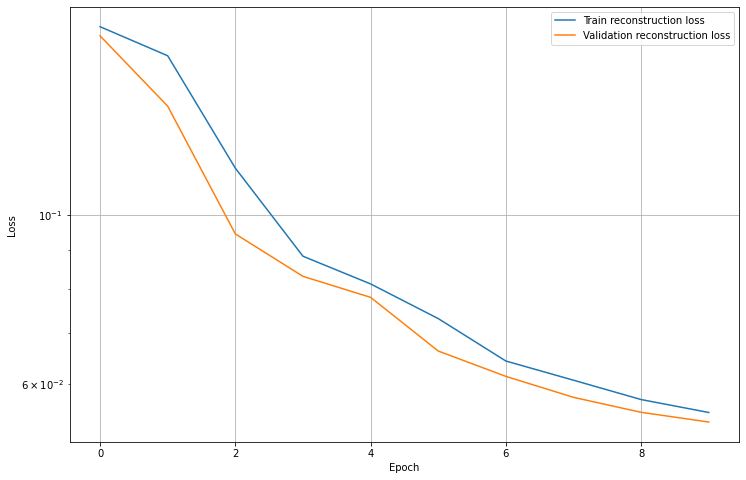

In [11]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train reconstruction loss')
plt.semilogy(val_loss_log, label='Validation reconstruction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

Example of recunstruction



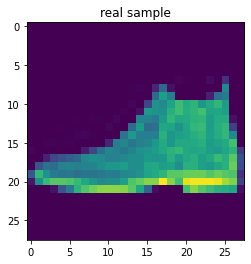

In [12]:
# actual data
sample_dataloader = torch.utils.data.DataLoader(
        torchvision.datasets.FashionMNIST(DIR, train=False, download=True, transform=transforms.ToTensor()),
        batch_size= 1,
        shuffle= False,
        num_workers= 2
    )
data, _ = next(iter(sample_dataloader))
plt.imshow(data.squeeze())
plt.title("real sample")
plt.show()

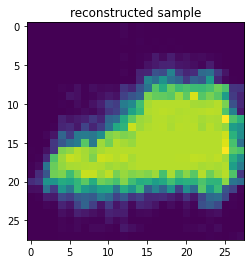

In [13]:
# recunstructed data

encoded_data = encoder(data.to(device))
reconstructed_data = decoder(encoded_data)
plt.imshow(reconstructed_data.squeeze().detach().cpu())
plt.title("reconstructed sample")
plt.show()

Laten Space

In [14]:
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

In [15]:
def latent_samples (dataset):  
  encoded_samples = []
  for sample in tqdm(dataset):
      img = sample[0].unsqueeze(0).to(device)
      label = sample[1]
      # Encode image
      encoder.eval()
      with torch.no_grad():
          encoded_img  = encoder(img)
      # Append to list
      encoded_img = encoded_img.flatten().cpu().numpy()
      encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
      encoded_sample['label'] = label
      encoded_samples.append(encoded_sample)
  return encoded_samples

In [16]:
# Get Latent Data
dataset_test_part  = torchvision.datasets.FashionMNIST(DIR,train=False,download=True,transform=transforms.ToTensor())

encoded_samples = latent_samples(dataset_test_part)
# change them to DataFrame
encoded_samples = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:09<00:00, 1004.20it/s]


In [17]:
fig_1 = px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
                   color=[label_names[l] for l in encoded_samples.label.to_numpy()],
                   opacity=0.7
                   )
fig_1.show()

Optimizing hyperparameters

In [18]:
def define_model(trial):
  # optimize dimention of latent space

  ### Initialize the two networks
  encoded_space_dim = trial.suggest_int('encoded_space_dim', 2, 20)
  encoder = Encoder(encoded_space_dim=encoded_space_dim)
  decoder = Decoder(encoded_space_dim=encoded_space_dim)
  return encoder , decoder

In [19]:
def objective(trial):

    # Generate the model.
    model_encoder, model_decoder = define_model(trial)
    model_encoder = model_encoder.to(device)
    model_decoder = model_decoder.to(device)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5,1e-1, log=True)
    params_to_optimize = [
    {'params': model_encoder.parameters()},
    {'params': model_decoder.parameters()}
    ]
    optimizer = getattr(torch.optim, optimizer_name)(params_to_optimize, lr=lr, weight_decay=weight_decay)
    
    loss_fn = torch.nn.MSELoss()

    # Get the FashionMNIST dataset.
    train_dataloader, test_dataloader = get_mnist()

    # Training of the model.
    num_epochs = 10
    for epoch in range(num_epochs):
        ### Training (use the training function)
        train_epoch(
            encoder=model_encoder, 
            decoder=model_decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optimizer)
        ### Validation  (use the testing function)
        val_acc , _ = test_epoch(
            encoder=model_encoder, 
            decoder=model_decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn)

        trial.report(val_acc, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            

    return val_acc


if __name__ == "__main__":
    sampler= optuna.samplers.TPESampler(seed=123)
    study = optuna.create_study(study_name="Autoencoder Task", direction="maximize", sampler= sampler)
    study.optimize(objective, n_trials=50, timeout=600)

    # pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    # complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
# 
    # print("Study statistics: ")
    # print("  Number of finished trials: ", len(study.trials))
    # print("  Number of pruned trials: ", len(pruned_trials))
    # print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-07-03 16:20:17,454] A new study created in memory with name: Autoencoder Task
[I 2022-07-03 16:20:30,968] Trial 0 finished with value: 84.86645966768265 and parameters: {'encoded_space_dim': 15, 'optimizer': 'SGD', 'lr': 0.0075487645402050295, 'weight_decay': 0.0004925222337791055}. Best is trial 0 with value: 84.86645966768265.
[I 2022-07-03 16:20:45,317] Trial 1 finished with value: 83.08900147676468 and parameters: {'encoded_space_dim': 20, 'optimizer': 'Adam', 'lr': 0.00023589137648150635, 'weight_decay': 0.008245155098953617}. Best is trial 0 with value: 84.86645966768265.
[I 2022-07-03 16:21:00,141] Trial 2 finished with value: 79.72420752048492 and parameters: {'encoded_space_dim': 10, 'optimizer': 'SGD', 'lr': 5.3699089471963626e-05, 'weight_decay': 5.032769318663507e-05}. Best is trial 0 with value: 84.86645966768265.
[I 2022-07-03 16:21:13,738] Trial 3 finished with value: 84.32058691978455 and parameters: {'encoded_space_dim': 12, 'optimizer': 'SGD', 'lr': 0.00790353

Best trial:
  Value:  97.81996924430132
  Params: 
    encoded_space_dim: 11
    optimizer: Adam
    lr: 0.02193285044803652
    weight_decay: 1.5465347324222177e-05


Using the best hyperparameters and find results with Cross_Validation method

In [27]:
# parameters
encoded_space_dim = trial.params['encoded_space_dim']
lr = trial.params['lr']
weight_decay = trial.params['weight_decay']

In [28]:
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)
encoder.to(device)
decoder.to(device)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [29]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay= weight_decay)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [30]:
# # Save network parameters
# torch.save(encoder.state_dict(), 'Optuna_encoder_params.pth')
# torch.save(decoder.state_dict(), 'Optuna_decoder_params.pth')
# # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training
# torch.save(optim.state_dict(), 'Optuna_optimizer_params.pth')

In [31]:
# # Load network parameters
# encoder.load_state_dict(torch.load('Optuna_encoder_params.pth'))
# decoder.load_state_dict(torch.load('Optuna_decoder_params.pth'))

In [32]:
# ### Load the optimizer parameters
# opt_state_dict = torch.load('Optuna_optimizer_params.pth')
# optim.load_state_dict(opt_state_dict)

In [33]:
k_fold = 10
num_epochs = 10
loss_fn = torch.nn.MSELoss()
# for Fold results
results = {}

torch.manual_seed(0)

dataset_train_part = torchvision.datasets.FashionMNIST(DIR, download=True, train=True, transform=transforms.ToTensor())
dataset_test_part = torchvision.datasets.FashionMNIST(DIR, download=True, train=False, transform=transforms.ToTensor())
dataset = ConcatDataset([dataset_train_part, dataset_test_part])

# define KFold cross_validation
kfold = KFold(n_splits=k_fold, shuffle=True)

#start print
print('--------------------------------')

# kfold cross validatio model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

  print(f'Fold {fold}')
  print('--------------------------------')


  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=BATCHSIZE,
                    sampler=train_subsampler,
                    num_workers= 2
                    )
  testloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=BATCHSIZE,
                    sampler=test_subsampler,
                    num_workers= 2
                    )
  
  for epoch in range(0, num_epochs):

      # Print epoch
      # print(f'Starting epoch {epoch+1}')

      # Set current loss value
      current_loss = 0.0

      # Iterate over the DataLoader for training data
      for i, (data,_) in enumerate(trainloader, 0):
        
        encoder.train()
        decoder.train()
        data = data.to(device)
        encoded_data = encoder(data)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data,data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0

  # Process is complete.
  print('Training process has finished. Saving trained model.')
  # Print about testing
  print('Starting testing')
  
  # Saving the model
  save_path_encoder = f'./encoder-fold-{fold}.pth'
  save_path_decoder = f'./decoder-fold-{fold}.pth'
  torch.save(encoder.state_dict(), save_path_encoder)
  torch.save(decoder.state_dict(), save_path_decoder)
  # Evaluationfor this fold
  accuracy = 0
  encoder.eval()
  decoder.eval()
  val_loss = []
  with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, (data,_) in enumerate(testloader, 0):
      data = data.to(device)
      encoded_data = encoder(data)
      decoded_data = decoder(encoded_data)
      loss = loss_fn(decoded_data,data)
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)
    accuracy = ( 1 - np.mean(val_loss) ) * 100
    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, accuracy))
    print('--------------------------------')
    results[fold] = accuracy
    
  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_fold} FOLDS')
  print('--------------------------------')
  sum = 0.0
  for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
  print(f'Average: {sum/len(results.items())} %')

--------------------------------
Fold 0
--------------------------------
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 0: 98 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 98.24887253344059 %
Average: 98.24887253344059 %
Fold 1
--------------------------------
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 1: 97 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 98.24887253344059 %
Fold 1: 97.79145959764719 %
Average: 98.02016606554389 %
Fold 2
--------------------------------
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 2: 98 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: 98.24887253344059 %
Fold 1: 97.79145959764719 %
Fold 2: 98.40368833392859 %


Latent Space Visualization

In [34]:
# Get Latent Data
encoded_samples_Optuna = latent_samples(dataset_test_part)
# change them to DataFrame
encoded_samples_Optuna = pd.DataFrame(encoded_samples_Optuna)

100%|██████████| 10000/10000 [00:07<00:00, 1384.48it/s]


In [35]:
# Perform TSNE on Test dataset

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples_Optuna)
# plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples_test.label.to_numpy())
# plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [36]:
TSNE_df = pd.DataFrame(encoded_samples_reduced_TSNE, columns={"Enc. Variable 0","Enc. Variable 1"})
TSNE_df['label'] = encoded_samples_Optuna.label
# TSNE_df


In [37]:
fig_2 = px.scatter(TSNE_df, x='Enc. Variable 0', y='Enc. Variable 1',
                   color=[label_names[l] for l in TSNE_df.label.to_numpy()],
                   opacity=0.7
                   )
fig_2.show()

Fine_Tuning the Unsupervised network with a supervised one

In [38]:
class Fine_Tune(nn.Module):
    
    def __init__(self, CLASSES):
        super().__init__()

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.linear = nn.Sequential(
            # First linear layer
            nn.Linear(in_features= 28*28 , out_features= 256),
            nn.ReLU(True),
            nn.Dropout(0.1),
            # Second linear layer
            nn.Linear(in_features= 256 , out_features= 64),
            nn.ReLU(True),
            nn.Dropout(0.1),
            # Third linear layer
            nn.Linear(in_features= 64, out_features= CLASSES),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        # Flatten
        x = self.flatten(x)
        # Linear layer
        x = self.linear(x)

        return x

In [39]:
# Fine_Tune = nn.Linear(in_features= encoded_space_dim, out_features= CLASSES)
# fine_tune = Fine_Tune.to(device)

In [40]:
fine_tune = Fine_Tune(CLASSES= CLASSES)
fine_tune.to(device)

Fine_Tune(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
    (7): LogSoftmax(dim=1)
  )
)

In [41]:
# Finding the accuracy of the network with K_Fold Cross validation

from torch.utils.data import ConcatDataset
k_fold = 10
num_epochs = 20
# for Fold results
results = {}
torch.manual_seed(0)

dataset_train_part = torchvision.datasets.FashionMNIST(DIR, download=True, train=True, transform=transforms.ToTensor())
dataset_test_part = torchvision.datasets.FashionMNIST(DIR, download=True, train=False, transform=transforms.ToTensor())
dataset = ConcatDataset([dataset_train_part, dataset_test_part])

# define KFold cross_validation
kfold = KFold(n_splits=k_fold, shuffle=True)

#start print
print('--------------------------------')

# kfold cross validatio model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

  print(f'Fold {fold}')
  print('--------------------------------')


  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=BATCHSIZE, sampler=train_subsampler,
                    num_workers= 2)
  testloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=BATCHSIZE, sampler=test_subsampler,
                    num_workers= 2)
  
  for epoch in range(0, num_epochs):

      # Set current loss value
      current_loss = 0.0
      encoder.train()
      fine_tune.train()
      # Iterate over the DataLoader for training data
      for batch_idx, (data, target) in enumerate(trainloader, 0):
        # Limiting training data for faster epochs.
        if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            break
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        encoded_data = encoder(data)
        decoded_data = decoder(encoded_data)
        output = fine_tune(decoded_data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

  # Process is complete.
  print('Training process has finished')
  # Print about testing
  print('Starting testing')
  
  # Evaluationfor this fold
  accuracy = 0
  correct = 0
  fine_tune.eval()
  val_loss = []
  with torch.no_grad():
    # Iterate over the test data and generate predictions
    for batch_idx, (data, target) in enumerate(testloader, 0):
      # Limiting validation data.
      if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
          break
      data, target = data.to(device), target.to(device)
      encoded_data = encoder(data)
      decoded_data = decoder(encoded_data)
      output = fine_tune(decoded_data)
      
      # Get the index of the max log-probability.
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / min(len(testloader.dataset), N_VALID_EXAMPLES)
    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (fold, accuracy*100))
    print('--------------------------------')
    results[fold] = accuracy
    
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_fold} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value*100} %')
  sum += value
print(f'Average: {(sum/len(results.items()))*100} %')

--------------------------------
Fold 0
--------------------------------
Training process has finished
Starting testing
Accuracy for fold 0: 10 %
--------------------------------
Fold 1
--------------------------------
Training process has finished
Starting testing
Accuracy for fold 1: 10 %
--------------------------------
Fold 2
--------------------------------
Training process has finished
Starting testing
Accuracy for fold 2: 9 %
--------------------------------
Fold 3
--------------------------------
Training process has finished
Starting testing
Accuracy for fold 3: 8 %
--------------------------------
Fold 4
--------------------------------
Training process has finished
Starting testing
Accuracy for fold 4: 9 %
--------------------------------
Fold 5
--------------------------------
Training process has finished
Starting testing
Accuracy for fold 5: 9 %
--------------------------------
Fold 6
--------------------------------
Training process has finished
Starting testing
Accuracy

Latent Space of Fine_Tune model

In [42]:
# Get Latent Data
encoded_samples_Optuna = latent_samples(dataset_test_part)
# change them to DataFrame
encoded_samples_Optuna = pd.DataFrame(encoded_samples_Optuna)

100%|██████████| 10000/10000 [00:07<00:00, 1363.31it/s]


In [43]:
# Perform TSNE on Test dataset

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples_Optuna)
# plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples_test.label.to_numpy())
# plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [44]:
TSNE_df = pd.DataFrame(encoded_samples_reduced_TSNE, columns={"Enc. Variable 0","Enc. Variable 1"})
TSNE_df['label'] = encoded_samples_Optuna.label
# TSNE_df

In [45]:
fig_3 = px.scatter(TSNE_df, x='Enc. Variable 0', y='Enc. Variable 1',
                   color=[label_names[l] for l in TSNE_df.label.to_numpy()],
                   opacity=0.7
                   )
fig_3.show()

Implement Variational AutoEncoder

In [46]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
BATCH_SIZE = 64               # number of data points in each batch
N_EPOCHS = 20                 # times to run the model on complete data
INPUT_DIM = 28 * 28           # size of each input
HIDDEN_DIM = 64               # hidden dimension
LATENT_DIM = 10               # latent vector dimension
lr = 1e-3                     # learning rate
weight_decay = 1e-5           # weight decay
DIR = 'classifier_data'       # directory of data

"""### Loading Data"""

transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(
    DIR,
    train=True,
    download=True,
    transform=transforms)

test_dataset = torchvision.datasets.FashionMNIST(
    DIR,
    train=False,
    download=True,
    transform=transforms
)

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

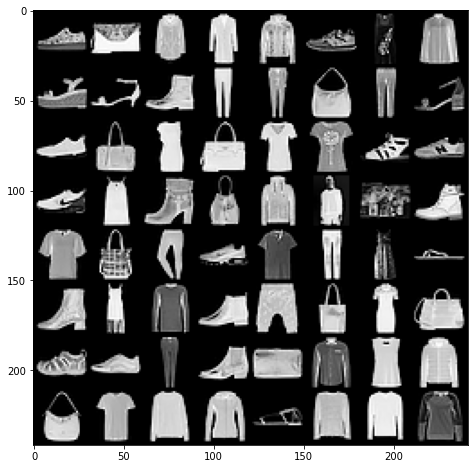

In [47]:
"""### Batch Visualization of Given Data"""

def visualize_data(batch):
    batch = torchvision.utils.make_grid(batch)
    batch = batch.numpy()
    batch = np.transpose(batch,(1,2,0))
    plt.figure(figsize = (8,8))
    plt.imshow(batch, cmap = 'Greys_r')
    plt.show()

batch,labels = iter(train_iterator).next()
visualize_data(batch)

In [48]:
class Encoder(nn.Module):
    
    def __init__(self, hidden_dim, z_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels= 1, out_channels= 8, kernel_size= 3, 
                      stride= 2, padding= 1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size= 3, 
                      stride= 2, padding= 1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= 3, 
                      stride= 2, padding= 0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features= 3*3*32, out_features= 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features= 128, out_features= hidden_dim)
        )
        
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)


    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        hidden = self.encoder_lin(x)
        # hidden is of shape [batch_size, hidden_dim]
        z_mu = self.mu(hidden)
        # z_mu is of shape [batch_size, latent_dim]
        z_var = self.var(hidden)
        # z_var is of shape [batch_size, latent_dim]

        return z_mu, z_var

In [49]:
class Decoder(nn.Module):
    
    def __init__(self, z_dim, hidden_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features= z_dim, out_features= hidden_dim),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features= hidden_dim, out_features= 3*3*32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels= 32, out_channels= 16, kernel_size= 3, 
                               stride= 2, output_padding= 0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels= 16, out_channels= 8, kernel_size= 3, 
                               stride= 2, padding= 1, output_padding= 1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels= 8, out_channels= 1, kernel_size= 3, 
                               stride= 2, padding= 1, output_padding= 1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        predicted = torch.sigmoid(x)
        return predicted

In [50]:
class VAE(nn.Module):
    def __init__(self, enc, dec):
        ''' This the VAE, which takes a encoder and decoder.
        '''
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        z_mu, z_var = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        # decode
        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var

In [55]:
from torch.optim.optimizer import Optimizer
# encoder
encoder = Encoder( HIDDEN_DIM, LATENT_DIM)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM)

# vae
model = VAE(encoder, decoder)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay= weight_decay)

In [56]:
encoder.to(device)
decoder.to(device)
model.to(device)

VAE(
  (enc): Encoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (5): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=64, bias=True)
    )
    (mu): Linear(in_features=64, out_features=10, bias=True)
    (var): Linear(in_features=64, out_features=10, bias=True)
  )
  (dec): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(di

In [57]:
# xavier weight initialization
def init_kaiming(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight)

model.apply(init_kaiming)

print(model)

VAE(
  (enc): Encoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (5): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=288, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=64, bias=True)
    )
    (mu): Linear(in_features=64, out_features=10, bias=True)
    (var): Linear(in_features=64, out_features=10, bias=True)
  )
  (dec): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(di

In [58]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, _) in enumerate(train_iterator):

        x = x.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, z_mu, z_var = model(x)

        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

        # kl divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        loss = recon_loss + kl_loss

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):

            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # reconstruction loss
            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

            # kl divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

            # total loss
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    return test_loss

In [59]:
def generate_data(bs=BATCH_SIZE):
    z = torch.randn(bs, LATENT_DIM).to(device)
    reconstructed_img = model.dec(z)
    img = reconstructed_img.view(-1,1,28, 28).data

    img = img.cpu()
    visualize_data(img)

N_EPOCHS = 20

In [60]:
def fit():
    best_test_loss = float('inf')
    print('Before Training : ')
    generate_data()

    for e in range(N_EPOCHS):

        train_loss = train()
        test_loss = test()

        train_loss /= len(train_dataset)
        test_loss /= len(test_dataset)
        
        print('*******************************')
        print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
        print('*******************************')
        generate_data()

        if best_test_loss > test_loss:
            best_test_loss = test_loss
            patience_counter = 1
        else:
            patience_counter += 1

        if patience_counter > 3:
            break

Before Training : 


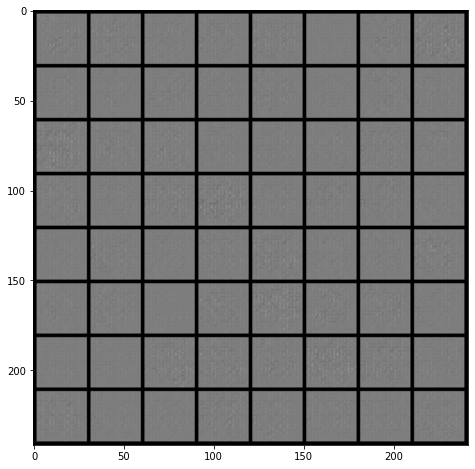

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



*******************************
Epoch 0, Train Loss: 289.10, Test Loss: 260.81
*******************************


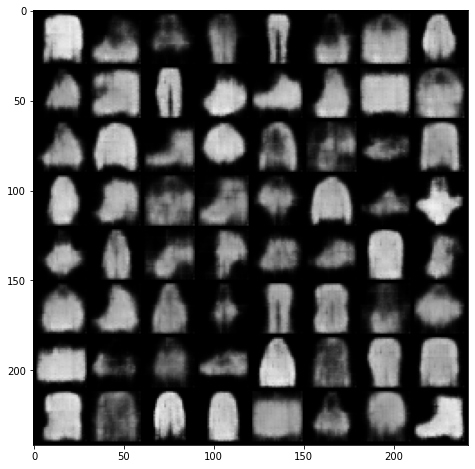

*******************************
Epoch 1, Train Loss: 255.58, Test Loss: 254.87
*******************************


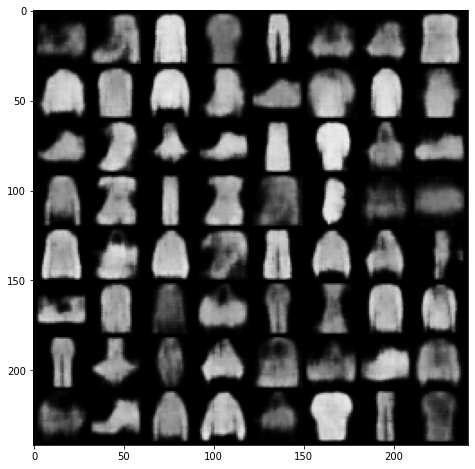

*******************************
Epoch 2, Train Loss: 251.18, Test Loss: 251.03
*******************************


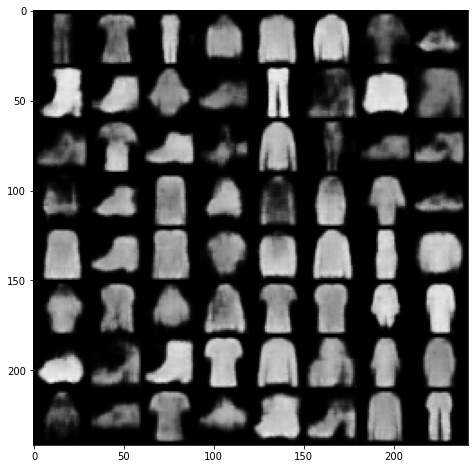

*******************************
Epoch 3, Train Loss: 248.83, Test Loss: 249.43
*******************************


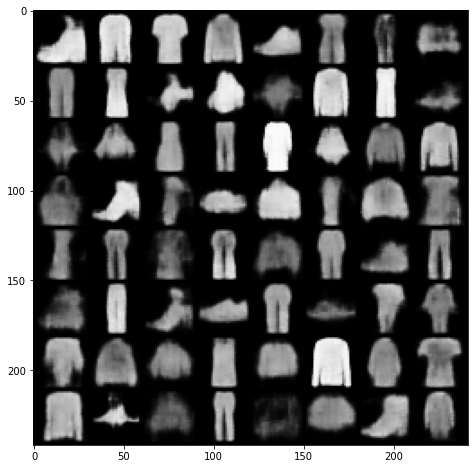

*******************************
Epoch 4, Train Loss: 247.34, Test Loss: 248.92
*******************************


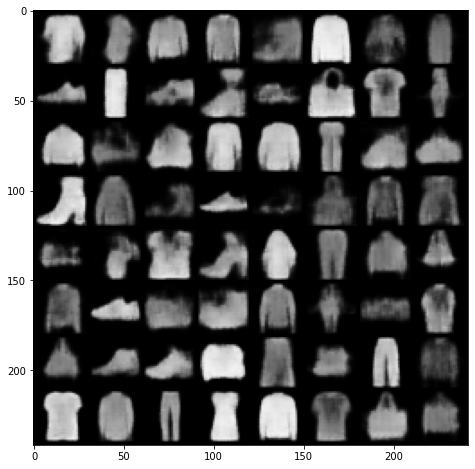

*******************************
Epoch 5, Train Loss: 246.19, Test Loss: 247.74
*******************************


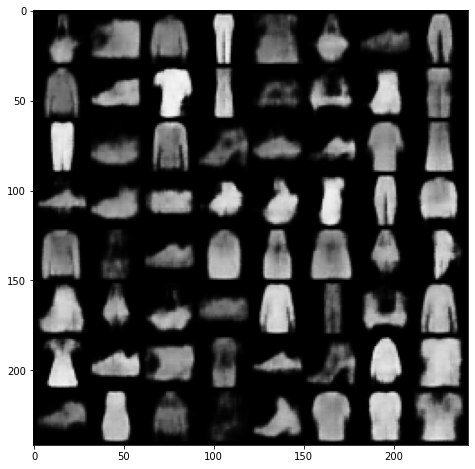

*******************************
Epoch 6, Train Loss: 245.33, Test Loss: 247.04
*******************************


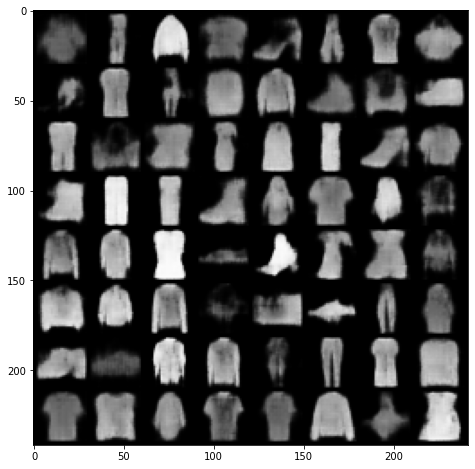

*******************************
Epoch 7, Train Loss: 244.59, Test Loss: 246.80
*******************************


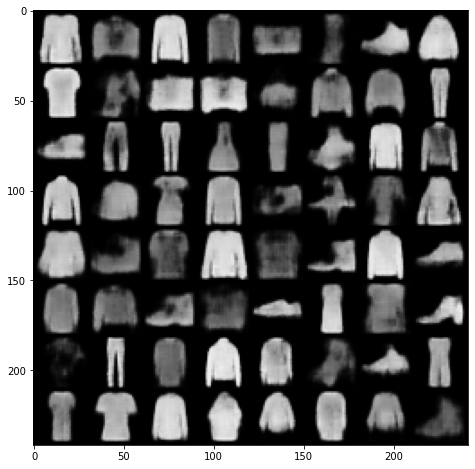

*******************************
Epoch 8, Train Loss: 244.01, Test Loss: 246.61
*******************************


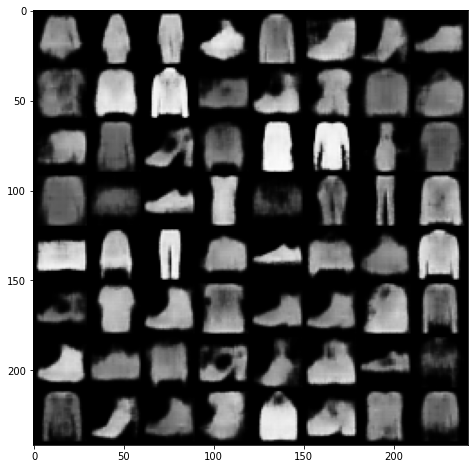

*******************************
Epoch 9, Train Loss: 243.48, Test Loss: 246.11
*******************************


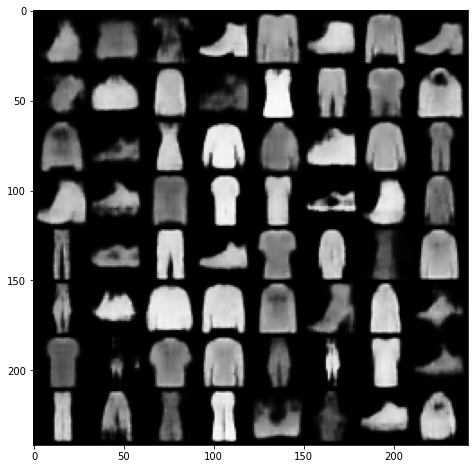

*******************************
Epoch 10, Train Loss: 243.11, Test Loss: 244.63
*******************************


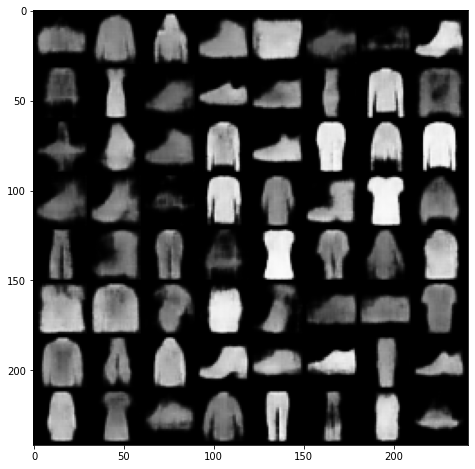

*******************************
Epoch 11, Train Loss: 242.72, Test Loss: 244.31
*******************************


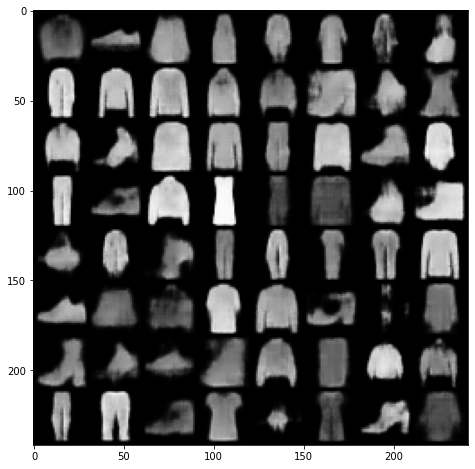

*******************************
Epoch 12, Train Loss: 242.43, Test Loss: 243.82
*******************************


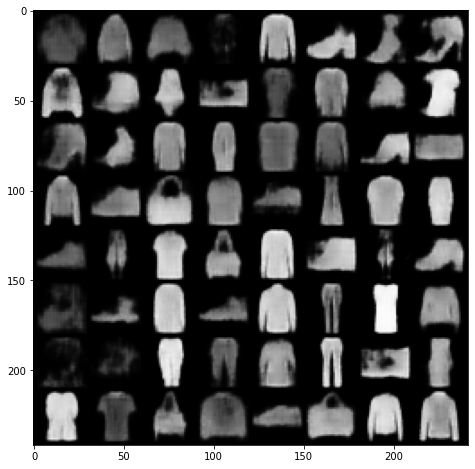

*******************************
Epoch 13, Train Loss: 242.15, Test Loss: 244.17
*******************************


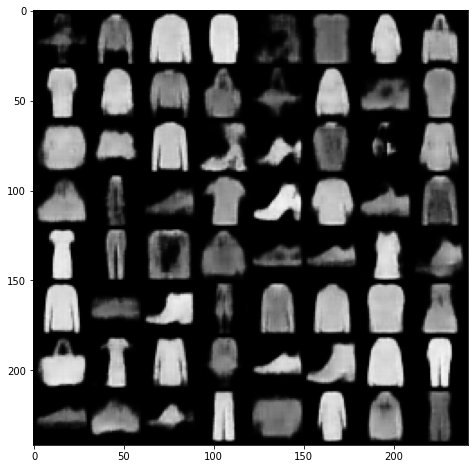

*******************************
Epoch 14, Train Loss: 241.92, Test Loss: 243.78
*******************************


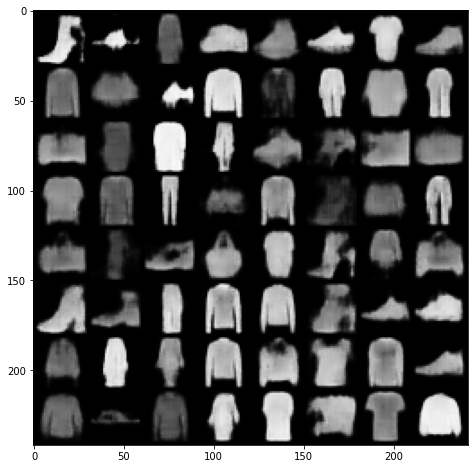

*******************************
Epoch 15, Train Loss: 241.71, Test Loss: 243.33
*******************************


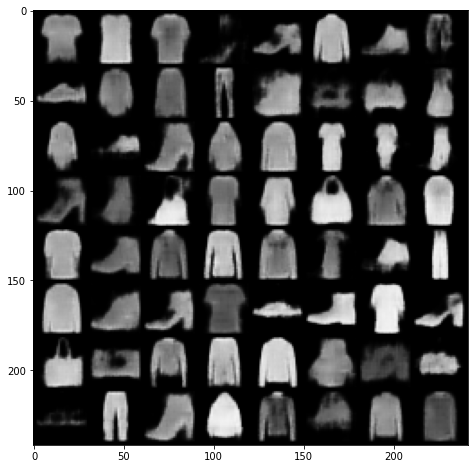

*******************************
Epoch 16, Train Loss: 241.50, Test Loss: 243.23
*******************************


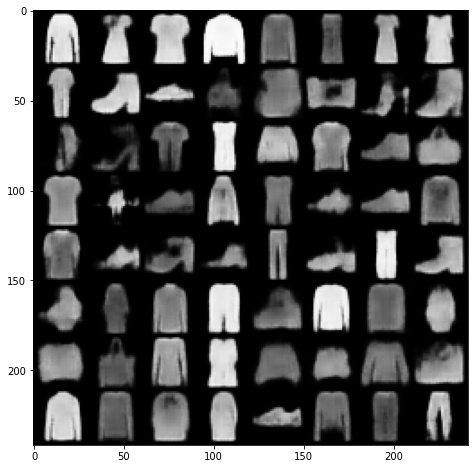

*******************************
Epoch 17, Train Loss: 241.32, Test Loss: 243.26
*******************************


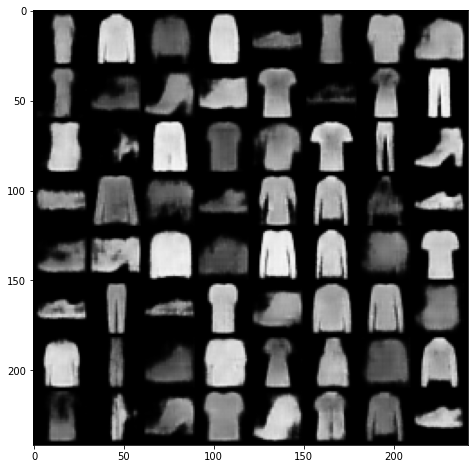

*******************************
Epoch 18, Train Loss: 241.18, Test Loss: 242.70
*******************************


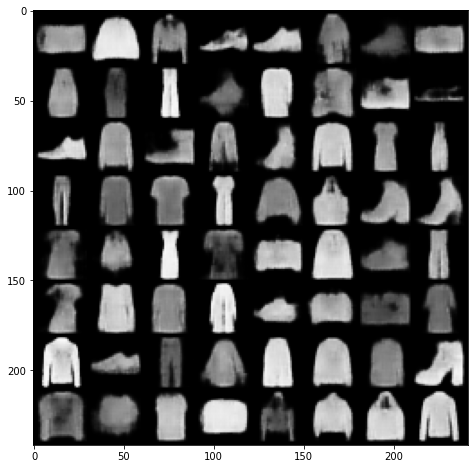

*******************************
Epoch 19, Train Loss: 241.04, Test Loss: 243.10
*******************************


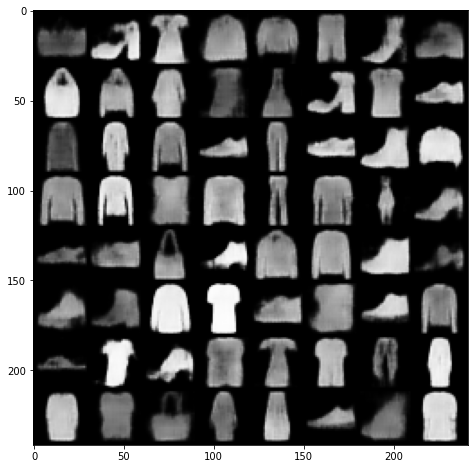

In [61]:
### Fit and train the model

fit()

Result of VAE

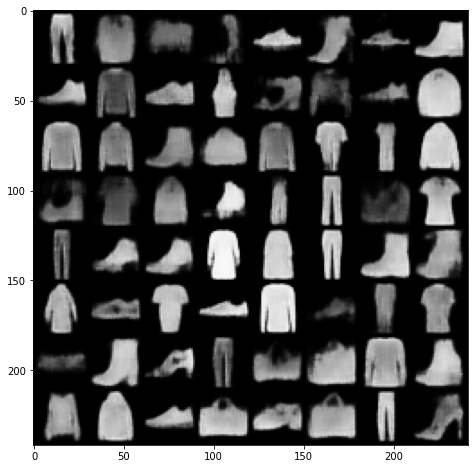

In [68]:
# This function will generate Batch Data

generate_data()

In [69]:
def latent_samples_VAE (dataset):
  encoded_samples = []
  for sample in tqdm(dataset):
      img = sample[0].unsqueeze(0).to(device)
      label = sample[1]
      # Encode image
      model.eval()
      with torch.no_grad():
          means , vars = model.enc(img)
      # Append to list
      encoded_img = means.squeeze().cpu().numpy()
      encoded_sample = {f"Enc. Variable {i}": enco for i, enco in enumerate(encoded_img)}
      encoded_sample['label'] = label
      encoded_samples.append(encoded_sample)
  return encoded_samples

In [70]:
# Get Latent Data
encoded_samples_VAE = latent_samples_VAE(test_dataset)
# change them to DataFrame
encoded_samples_VAE = pd.DataFrame(encoded_samples_VAE)

100%|██████████| 10000/10000 [00:08<00:00, 1187.09it/s]


In [71]:
# Perform TSNE on Test dataset

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples_VAE)
# plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples_test.label.to_numpy())
# plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [72]:
TSNE_df = pd.DataFrame(encoded_samples_reduced_TSNE, columns={"Enc. Variable 0","Enc. Variable 1"})
TSNE_df['label'] = encoded_samples_VAE.label
# TSNE_df

In [73]:
fig_4 = px.scatter(TSNE_df, x='Enc. Variable 0', y='Enc. Variable 1',
                   color=[label_names[l] for l in TSNE_df.label.to_numpy()],
                   opacity=0.7
                   )
fig_4.show()